## Manage Colab Env/WD

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import json
from datetime import date
import traceback
import requests
import os
import pandas as pd

import torch
import torch.nn as nn

import glob
import librosa
import numpy as np
import collections
import contextlib
import sys
import wave

term = '2020'
docket = '18-540'
mod_path = "/content/model.model"
ap = '18-540_20201006-argument.delivery.mp3'
ap_wav = '18-540_argument.wav'

In [3]:
!ls -ag

total 20
drwxr-xr-x 1 root 4096 Oct 31 20:14 .
drwxr-xr-x 1 root 4096 Oct 31 20:10 ..
drwxr-xr-x 1 root 4096 Oct 28 16:30 .config
drwx------ 5 root 4096 Oct 31 20:14 drive
drwxr-xr-x 1 root 4096 Oct 28 16:30 sample_data


In [9]:
!ls drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/ -ag

total 55518
-rw------- 1 root  7915975 Oct 19 00:53 case_summaries.json
drwx------ 2 root     4096 Oct 19 02:28 config
-rw------- 1 root     2684 Oct 18 16:50 data_load.py
-rw------- 1 root     3405 Oct 18 21:54 data_preprocess.py
-rw------- 1 root     4018 Oct 12 00:54 dvector_create.py
-rw------- 1 root    65693 Oct 24 20:00 d-vector_generation.ipynb
-rw------- 1 root     1591 Oct 18 16:51 hparam.py
-rw------- 1 root 48543272 Oct 19 17:53 model.model
drwx------ 2 root     4096 Oct 23 17:32 notes
drwx------ 2 root     4096 Oct 23 14:01 oyez_parser
drwx------ 2 root     4096 Oct 19 02:54 __pycache__
-rw------- 1 root    11539 Oct 19 17:58 run_TIMIT_test.ipynb
-rw------- 1 root   251947 Oct 19 17:43 run_train.ipynb
-rw------- 1 root     1595 Oct 18 16:56 speech_embedder_net.py
drwx------ 2 root     4096 Oct 30 18:32 speech_id_checkpoint_1019
lrw------- 1 root        0 Oct 24 17:49 test_tisv -> '/content/drive/ '
-rw------- 1 root     7109 Oct 18 21:56 train_speech_embedder.py
drwx------

In [10]:
!ls drive/My\ Drive/Colab\ Notebooks/diarization -ag

total 68
-rw------- 1 root 65005 Oct 31 20:42 d-vector_generation.ipynb
-rw------- 1 root  4377 Oct 19 01:56 PyTorchSV.ipynb


# Get desired audio file + transript/times from web 
  - mostly to understand audio data scraping tools
  - test utilization in colab

In [13]:
# Add court summaries file to WD
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/case_summaries.json /content/

In [14]:
def get_http_json(url):
    print(f"Getting {url}")
    response = requests.get(url)
    parsed = response.json()
    return parsed

def get_case(term, docket):
    """Get the info of the case and fetch all
    transcripts that the info links to"""
    url = f"https://api.oyez.org/cases/{term}/{docket}"
    docket_data = get_http_json(url)

    if not (
        "oral_argument_audio" in docket_data and docket_data["oral_argument_audio"]
    ):
        # no oral arguments for this case yet
        # fail so we will try again later
        print(f"No oral arguments for docket {docket}")
        return (docket_data, [])

    oral_argument_audio = docket_data["oral_argument_audio"]
    transcripts = []
    for link in oral_argument_audio:
        t = get_http_json(link["href"])
        transcripts.append(t)

    return docket_data, transcripts

def getTranscript(transcripts):
    transcript_list = []
    speaker_list = []
    speaker_type_list = []
    time_list = []
    
    for t in transcripts:
        sections = t['transcript']['sections']
        for section in sections:
            turns = section['turns']
            for turn in turns:
                
                try:
                    speaker = turn['speaker']['name']
                except:
                    speaker = '<UNK>'
                speaker_list.append(speaker)   
                
                roles = turn['speaker']['roles']
                if isinstance(roles, list):
                    multiple_roles = []
                    for role in roles:
                        multiple_roles.append(role['type'])
                    speaker_type_list.append(multiple_roles)
                
                else:
                    speaker_type_list.append(['Other']) #Other is most likely Lawyer
                
                
                texts = turn['text_blocks']
                texts_out = []
                times_out = []
                for text in texts:
                    texts_out.append(text['text'])
                    times_out.append((text['start'],text['stop']))
                
                transcript_list.append(texts_out)
                time_list.append(times_out)

    return transcript_list, speaker_list, speaker_type_list, time_list

def getAudio(transcripts):
    num_files = len(transcripts)
    audio_list = []
    for t in transcripts:
        media_dicts = t['media_file']
        #just incase theres more than one, there shouldnt be but they re in a weird list
        for media_dict in media_dicts:
            audio_list.append(media_dict['href'])
    return [num_files,audio_list]

In [15]:
# Get all the terms and dockets from case_summaries.json file
with open(os.getcwd() + '/case_summaries.json') as f:
    data = json.load(f)
    
case_summaries = pd.DataFrame(data)
case_summaries = case_summaries[['term', 'docket_number']]
# Let's start with 2020
case_summaries_2020 = case_summaries[case_summaries['term']=='2020']

In [16]:
data = {}

for term, docket_number in case_summaries_2020.itertuples(index=False):
    docket_data, transcripts = get_case(term, docket_number)
    data[docket_number] = transcripts

Getting https://api.oyez.org/cases/2020/18-540
Getting https://api.oyez.org/case_media/oral_argument_audio/25077
Getting https://api.oyez.org/cases/2020/19-71
Getting https://api.oyez.org/case_media/oral_argument_audio/25058
Getting https://api.oyez.org/cases/2020/19-368
Getting https://api.oyez.org/case_media/oral_argument_audio/25061
Getting https://api.oyez.org/cases/2020/19-309
Getting https://api.oyez.org/case_media/oral_argument_audio/25055
Getting https://api.oyez.org/cases/2020/18-956
Getting https://api.oyez.org/case_media/oral_argument_audio/25068


In [17]:
audio_path = getAudio(data[docket])[1][0].strip("'")

In [21]:
transcript_list, speaker_list, speaker_type_list, time_list = getTranscript(transcripts)

In [18]:
?#Add mp3 file to WD as determined thru getAudio function
!wget $audio_path

--2020-10-31 20:44:16--  https://s3.amazonaws.com/oyez.case-media.mp3/case_data/2020/18-540/18-540_20201006-argument.delivery.mp3
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.86.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.86.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17200673 (16M) [audio/mpeg]
Saving to: ‘18-540_20201006-argument.delivery.mp3’

18-540_20201006-arg 100%[===================>]  16.40M  97.0MB/s    in 0.2s    

2020-10-31 20:44:17 (97.0 MB/s) - ‘18-540_20201006-argument.delivery.mp3’ saved [17200673/17200673]



# Define and Load SpeechEmbedder()
  - Manually define SpeechEmbedder (could use import, demands files)
  - manually load model checkpoint `mod_path`
  - can resave, continue training, test

#### copy necessary files for defining network
  - hparam.py
  - config/config.yaml
  - utils.py
  - model checkpoint `model.model`
  - could import all files (not necessary)

In [28]:
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/model.model /content/

In [29]:
!cp -r drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/config .

In [30]:
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/hparam.py .

In [31]:
!cp drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/utils.py .

In [ ]:
#Add PyTorch_SV git repo files from google drive to colab drive mount (/content/)
#!cp -r drive/My\ Drive/1006:\ Term\ Project/Colab\ Notebooks/*.py .

In [32]:
!ls  -ag

total 71976
drwxr-xr-x 1 root     4096 Oct 31 20:50 .
drwxr-xr-x 1 root     4096 Oct 31 20:10 ..
-rw-r--r-- 1 root 17200673 Oct 22 16:15 18-540_20201006-argument.delivery.mp3
-rw------- 1 root  7915975 Oct 31 20:44 case_summaries.json
drwx------ 2 root     4096 Oct 31 20:50 config
drwxr-xr-x 1 root     4096 Oct 28 16:30 .config
drwx------ 5 root     4096 Oct 31 20:14 drive
-rw------- 1 root     1591 Oct 31 20:50 hparam.py
-rw------- 1 root 48543272 Oct 31 20:50 model.model
drwxr-xr-x 1 root     4096 Oct 28 16:30 sample_data
-rw------- 1 root     6890 Oct 31 20:50 utils.py


#### Load SpeechEmbedder
  - embedder_net w/ final checkpoint params

In [33]:
from hparam import hparam as hp
from utils import get_centroids, get_cossim, calc_loss

class SpeechEmbedder(nn.Module):
    
    def __init__(self):
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(hp.data.nmels, hp.model.hidden, num_layers=hp.model.num_layer, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
          if 'bias' in name:
             nn.init.constant_(param, 0.0)
          elif 'weight' in name:
             nn.init.xavier_normal_(param)
        self.projection = nn.Linear(hp.model.hidden, hp.model.proj)
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels)
        #only use last frame
        x = x[:,x.size(1)-1]
        x = self.projection(x.float())
        x = x / torch.norm(x, dim=1).unsqueeze(1)
        return x

In [34]:
embedder_net = SpeechEmbedder()
chk = torch.load(mod_path)

In [35]:
embedder_net.load_state_dict(chk)

<All keys matched successfully>

In [ ]:
#Add TIMIT test data to colab drive mount (if you want to evaluate model)
#!cp -r drive/My\ Drive/1006\ Colab\ Notebooks/test_tisv .

In [ ]:
# Resave model as state_dict
#torch.save(model.state_dict(), "drive/My Drive/Colab Notebooks/model_statedict.pt")

# d-Vector engineering
  - process audio file
  - compile `dvector_create.py` inner training loop for single (full) argument
  - output embedding of argument (subsample of argument)

#### colab package installs
  - install/import webrtcvad (VAD_chunk)
  - install/import pydub (mp3 $\rightarrow$ wav)

In [36]:
# Install webrtcvad in google colab (must be ran every time)
!pip install webrtcvad

     |████████████████████████████████| 71kB 6.3MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp36-cp36m-linux_x86_64.whl size=71404 sha256=9b063a426cf0aa7ed5909c1b97455e4bde6bea1b276297ff3a930f74a7c84a07
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad


In [37]:
!pip install pydub

In [38]:
import pydub
import webrtcvad

### Construct Single d-vector manually
  - independently define `dvector_create.py, VAD_segments.py` functions
  - mp3 (could be flacc) audio file  $\rightarrow$ properly sampled .wav 
  - .wav $\rightarrow$ STFT representation of full audio file
  - Analyze speaker alignment challenge (for labelled data)
  - `VAD_chunk()`, `concat_segs()`, `get_STFT()`
  - utilize `SpeechEmbedder()`
  - *ToDo: perform alignment concatenation*

#### .py functions

In [39]:
def concat_segs(times, segs):
    #Concatenate continuous voiced segments
    concat_seg = []
    seg_concat = segs[0]
    for i in range(0, len(times)-1):
        if times[i][1] == times[i+1][0]:
            seg_concat = np.concatenate((seg_concat, segs[i+1]))
        else:
            concat_seg.append(seg_concat)
            seg_concat = segs[i+1]
    else:
        concat_seg.append(seg_concat)
    return concat_seg

def get_STFTs(segs):
    #Get 240ms STFT windows with 50% overlap
    sr = hp.data.sr
    STFT_frames = []
    for seg in segs:
        S = librosa.core.stft(y=seg, n_fft=hp.data.nfft,
                              win_length=int(hp.data.window * sr), hop_length=int(hp.data.hop * sr))
        S = np.abs(S)**2
        mel_basis = librosa.filters.mel(sr, n_fft=hp.data.nfft, n_mels=hp.data.nmels)
        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
        for j in range(0, S.shape[1], int(.12/hp.data.hop)):
            if j + 24 < S.shape[1]:
                STFT_frames.append(S[:,j:j+24])
            else:
                break
    return STFT_frames

def align_embeddings(embeddings):
    partitions = []
    start = 0
    end = 0
    j = 1
    for i, embedding in enumerate(embeddings):
        if (i*.12)+.24 < j*.401:
            end = end + 1
        else:
            partitions.append((start,end))
            start = end
            end = end + 1
            j += 1
    else:
        partitions.append((start,end))
    avg_embeddings = np.zeros((len(partitions),256))
    for i, partition in enumerate(partitions):
        avg_embeddings[i] = np.average(embeddings[partition[0]:partition[1]],axis=0) 
    return avg_embeddings


def read_wave(path, sr):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    Assumes sample width == 2
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
    data, _ = librosa.load(path, sr)
    assert len(data.shape) == 1
    assert sr in (8000, 16000, 32000, 48000)
    return data, pcm_data
    
class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.
    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.
    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.
    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.
    Arguments:
    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).
    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                start = ring_buffer[0][0].timestamp
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                yield (start, frame.timestamp + frame.duration)
                ring_buffer.clear()
                voiced_frames = []
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield (start, frame.timestamp + frame.duration)


def VAD_chunk(aggressiveness, path):
    audio, byte_audio = read_wave(path, hp.data.sr)
    vad = webrtcvad.Vad(int(aggressiveness))
    frames = frame_generator(20, byte_audio, hp.data.sr)
    frames = list(frames)
    times = vad_collector(hp.data.sr, 20, 200, vad, frames)
    speech_times = []
    speech_segs = []
    for i, time in enumerate(times):
        start = np.round(time[0],decimals=2)
        end = np.round(time[1],decimals=2)
        j = start
        while j + .4 < end:
            end_j = np.round(j+.4,decimals=2)
            speech_times.append((j, end_j))
            speech_segs.append(audio[int(j*hp.data.sr):int(end_j*hp.data.sr)])
            j = end_j
        else:
            speech_times.append((j, end))
            speech_segs.append(audio[int(j*hp.data.sr):int(end*hp.data.sr)])
    return speech_times, speech_segs

#### audio processing


In [40]:
#mp3 to wav with predefined frame_rate/sample_rate 

#!rm 18-540_argument.wav
sound = pydub.AudioSegment.from_mp3(ap)
sound = sound.set_frame_rate(hp.data.sr)
sound.export(ap_wav, format="wav")

<_io.BufferedRandom name='18-540_argument.wav'>

In [41]:
train_sequence = []
train_cluster_id = []
label = 0
count = 0
train_saved = False

In [42]:
'''
2 -> webrtcvad.Vad(2)
webrtcvad github: aggressiveness mode, 
which is an integer between 0 and 3. 
0 is the least aggressive about 
filtering out non-speech, 
3 is the most aggressive.
'''

times, segs = VAD_chunk(2, ap_wav)

##### Analyzing Speaker Alignment Issue
  -  d-vectorization process re-organizes sound
  - need to retain alignment
  -  generally, sound-transcription aligning should be handled in `concat_segs`
  - **Since we are engineering our data to enter the pipeline in the same format/structure as the original implementation, we need to link each resulting embedding with its start & end time then we just concatenate all the embeddings for a case in the proper order and keep the labels**

Methodology:
  + sentence/utterance (however we divide it) by **one** speaker enters pipeline
    - comes with time started, time ended
  + utterance gets chopped up (`VAD_chunk()`, `concat_segs()`, `get_STFT()`) => LMS (slices X log-melspectrogram)
    - we lose where each word takes place in time in this process, but I dont think we care
  + LMS -> SpeechEmbedder() => `embeddings` (slices X 256)
  + tuple time started, time ended, `embeddings` & add to list 
  + order list & concat embeddings

In [59]:
len(time_list)

233

In [77]:
t = []
for tl in time_list:
  t.append(tl[-1][-1])

In [78]:
len(t)

233

In [81]:
t[0:5]

[7.24, 140.96, 161.56, 176.72, 177.48]

In [86]:
time_list[0:5]

[[(0, 7.24)],
 [(7.24, 15.56),
  (15.56, 18.76),
  (18.76, 28.64),
  (28.64, 63.52),
  (63.52, 75.72),
  (75.72, 90.12),
  (90.12, 96.64),
  (96.64, 109),
  (109, 115.04),
  (115.04, 120.68),
  (120.68, 131.48),
  (131.48, 140.96)],
 [(140.96, 161.56)],
 [(161.56, 161.92), (161.92, 163.88), (163.88, 168.36), (168.36, 176.72)],
 [(176.72, 177.48)]]

In [68]:
transcript_list[0]

['We will hear argument first this morning in Case 18-956, Google versus Oracle. Mr. Goldstein.']

In [69]:
transcript_list[1]

['Mr. Chief Justice, and may it please the Court: The merger doctrine resolved the copyrightability question in this case.',
 'Oracle has a copyright to the computer code in Java SE but not a patent.',
 "That means that the public, not Oracle, has the right to Java SE's function, and Oracle cannot leverage its copyright to create patent-like rights.",
 "Specifically, under the merger doctrine, there is no copyright protection for computer code that is the only way to perform those functions. Here, Java software developers have the right to use certain commands to create applications for Google's Android smartphone platform, but, to work, the commands require Google to reuse an exact set of declarations from Java SE, like a key that fits into a lock. Because there are no substitutes, Oracle is impermissibly claiming the exclusive right not merely to what the declarations say but also to what the declarations do.",
 'That is not a copyright; it is a patent right. With respect to fair use

#### audio processing contd

In [54]:
# probably where we will need to 
# keep track of our alignment 
# with speaker labels
concat_seg = concat_segs(times, segs)

In [57]:
len(concat_seg)

573

In [58]:
print(type(times))
print(type(times[0]))
print(type(segs))
print(type(segs[0]))
print("times[0]:", times[0])
print("times[1]:", times[1])
print("times[-2]:", times[-2])
print("times[-1]:", times[-1])
print("segs[0] shape:", np.shape(segs[0])[0])

<class 'list'>
<class 'tuple'>
<class 'list'>
<class 'numpy.ndarray'>
times[0]: (0.1, 0.5)
times[1]: (0.5, 0.9)
times[-2]: (4292.4, 4292.8)
times[-1]: (4292.8, 4292.82)
segs[0] shape: 6400


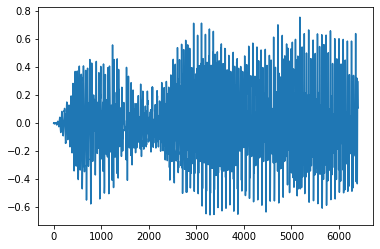

In [ ]:
# Visualization of sound wave estimation 
# for time slice where voice activity is detected
import matplotlib.pyplot as plt
plt.plot(range(np.shape(segs[0])[0]), segs[0])
plt.show()

In [84]:
'''
Short Time Fourier Transform
from function comments: 240ms STFT windows with 50% overlap
outputs 40 X 24 -> 
  - 40=number of mel energies (hparam)
  - 24 = ?...
'''
STFT_frames = get_STFTs(concat_seg)

In [85]:
len(STFT_frames)

33349

In [82]:
len(concat_seg)

573

In [ ]:
print("# frames (depends on file size):", len(STFT_frames))
print("Predefined output shape:", np.shape(STFT_frames[0]))

# frames (depends on file size): 33349
Predefined output shape: (40, 24)


In [ ]:
# reshape & convert to tensor
STFT_frames = np.stack(STFT_frames, axis=2)
STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
print("STFT size:", STFT_frames.size())

STFT size: torch.Size([33349, 24, 40])


In [ ]:
# 33349 to large for available RAM in Colab (total of 10GB i think!)
# 500 slice limit sample for testing
# send to device here to save RAM
STFT_sample = STFT_frames[0:500, :, :].to(hp.device)

#### Embedding

In [ ]:
# Generate embedding
# model will be on eval for court arguments
embedder_net.eval()
embedder_net.to(hp.device)
embeddings = embedder_net(STFT_sample)

In [ ]:
embeddings.size()

torch.Size([500, 256])

In [ ]:
# our first dvector 
embeddings[0,:]

tensor([-0.1240,  0.0455,  0.0003,  0.0453,  0.0002,  0.1131,  0.0588,  0.0170,
         0.0087, -0.0361, -0.0113,  0.0544, -0.0334, -0.0327, -0.0378,  0.0191,
         0.0196, -0.0374, -0.0074,  0.0381, -0.0815, -0.0518, -0.0827, -0.1062,
        -0.0139,  0.0607,  0.1170, -0.0645,  0.0676,  0.0091, -0.0537, -0.0237,
        -0.0245, -0.0499, -0.0737, -0.0739,  0.2134,  0.0644,  0.0091,  0.0070,
         0.0435, -0.0402,  0.0098, -0.0025, -0.0934,  0.0739, -0.0394,  0.0501,
         0.0916,  0.0941,  0.0465, -0.0052, -0.0636,  0.0353,  0.0458, -0.1032,
         0.0343, -0.0608, -0.0391,  0.0025,  0.0645,  0.0642, -0.0426, -0.0322,
         0.0850, -0.1075, -0.1069, -0.1096, -0.0256,  0.0701, -0.0467, -0.0091,
        -0.1201, -0.0914,  0.0242,  0.0347, -0.0058,  0.0011, -0.0058,  0.0547,
         0.0149,  0.0378, -0.0487,  0.0207,  0.0200,  0.0044,  0.0593, -0.0604,
        -0.0488, -0.0832,  0.0082, -0.0368,  0.0276,  0.0317, -0.0365,  0.0466,
        -0.0534, -0.0883, -0.0082,  0.07

# PyTorch SV dvector_create guts
  - dont run, just for reference


In [ ]:
times, segs = VAD_chunk(2, ap_wav)
if segs == []:
    print('No voice activity detected')
else:
  print("proceeding") 
concat_seg = concat_segs(times, segs)
STFT_frames = get_STFTs(concat_seg)
STFT_frames = np.stack(STFT_frames, axis=2)
STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
print("up to embedder")
embeddings = embedder_net(STFT_frames)
aligned_embeddings = align_embeddings(embeddings.detach().numpy())
train_sequence.append(aligned_embeddings)
for embedding in aligned_embeddings:
    train_cluster_id.append(str(label))
if count == 0:
    print('Processed {0}/{1} files'.format(count, len(audio_path)))

In [ ]:
path = ap_wav
with contextlib.closing(wave.open(path, 'rb')) as wf:
  print("test:", wf.getframerate())
  num_channels = wf.getnchannels()
  assert num_channels == 1
  sample_width = wf.getsampwidth()
  assert sample_width == 2
  sample_rate = wf.getframerate()
  assert sample_rate in (8000, 16000, 32000, 48000)
  pcm_data = wf.readframes(wf.getnframes())
data, _ = librosa.load(path, sr)
assert len(data.shape) == 1
assert sr in (8000, 16000, 32000, 48000)

test: 16000


In [ ]:
train_sequence = np.concatenate(train_sequence,axis=0)
train_cluster_id = np.asarray(train_cluster_id)

In [ ]:
!python dvector_create.py

Traceback (most recent call last):
  File "dvector_create.py", line 119, in <module>
    train_sequence = np.concatenate(train_sequence,axis=0)
  File "<__array_function__ internals>", line 6, in concatenate
ValueError: need at least one array to concatenate
